# Hubmap Keras BCE Loss Baseline
78.8% val

Clean version of HUBMAP using Keras implementation and BCE Loss, baseline

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Aug 17 19:01:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kinder","key":"f4bc44bce13f4078b647365aedad8d0d"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                             title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ruchi798/data-science-job-salaries                              Data Science Job Salaries                        7KB  2022-06-15 08:59:12          20488        637  1.0              
deepcontractor/mcdonalds-india-menu-nutrition-facts             McDonald's India : Menu Nutrition Dataset        5KB  2022-07-28 17:08:52           1464         87  0.9411765        
gpreda/life-expectancy-in-europe-by-age-and-sex                 Life Expectancy in Europe by Age and Sex         4MB  2022-08-12 15:28:01            528         28  1.0              
arianazmoudeh/airbnbopendata                                    Airbnb Open Data     

In [ ]:
! kaggle competitions download -c hubmap-organ-segmentation

100% 5.76G/5.78G [00:32<00:00, 191MB/s]
100% 5.78G/5.78G [00:32<00:00, 191MB/s]


In [ ]:
! unzip -q hubmap-organ-segmentation.zip

## Preparing the data

In [ ]:
import pandas as pd

In [ ]:
train_df = pd.read_csv("train.csv")
train_df.head()

id     organ data_source  img_height  img_width  pixel_size  \
0  10044  prostate         HPA        3000       3000         0.4   
1  10274  prostate         HPA        3000       3000         0.4   
2  10392    spleen         HPA        3000       3000         0.4   
3  10488      lung         HPA        3000       3000         0.4   
4  10610    spleen         HPA        3000       3000         0.4   

   tissue_thickness                                                rle   age  \
0                 4  1459676 77 1462675 82 1465674 87 1468673 92 14...  37.0   
1                 4  715707 2 718705 8 721703 11 724701 18 727692 3...  76.0   
2                 4  1228631 20 1231629 24 1234624 40 1237623 47 12...  82.0   
3                 4  3446519 15 3449517 17 3452514 20 3455510 24 34...  78.0   
4                 4  478925 68 481909 87 484893 105 487863 154 4908...  21.0   

      sex  
0    Male  
1    Male  
2    Male  
3    Male  
4  Female

In [ ]:
#get only ones with img height at 3000, for consistency??
train_df = train_df.loc[train_df['img_height'] == 3000]

In [ ]:
#326
len(train_df)

326

In [ ]:
#reset index since taking subset above has wrong indices, which we need later
train_df = train_df.reset_index(drop=True)

In [ ]:
#make sure bottom is row 325, thus we have right indices
train_df

id           organ data_source  img_height  img_width  pixel_size  \
0    10044        prostate         HPA        3000       3000         0.4   
1    10274        prostate         HPA        3000       3000         0.4   
2    10392          spleen         HPA        3000       3000         0.4   
3    10488            lung         HPA        3000       3000         0.4   
4    10610          spleen         HPA        3000       3000         0.4   
..     ...             ...         ...         ...        ...         ...   
321   9470          kidney         HPA        3000       3000         0.4   
322   9517          kidney         HPA        3000       3000         0.4   
323   9777  largeintestine         HPA        3000       3000         0.4   
324   9791          kidney         HPA        3000       3000         0.4   
325   9904  largeintestine         HPA        3000       3000         0.4   

     tissue_thickness                                                rle  \
0                   4  1459676 77 1462675 82 1465674 87 1468673 92 14...   
1                   4  715707 2 718705 8 721703 11 724701 18 727692 3...   
2                   4  1228631 20 1231629 24 1234624 40 1237623 47 12...   
3                   4  3446519 15 3449517 17 3452514 20 3455510 24 34...   
4                   4  478925 68 481909 87 484893 105 487863 154 4908...   
..                ...                                                ...   
321                 4  3969980 35 3970027 28 3972971 88 3975966 97 39...   
322                 4  1611763 11 1614753 29 1617750 35 1620746 43 16...   
323                 4  538473 13 541468 22 544463 30 547461 35 550459...   
324                 4  334733 33 337729 43 340729 43 343725 51 346723...   
325                 4  1009165 7 1012149 28 1015140 38 1018127 51 102...   

      age     sex  
0    37.0    Male  
1    76.0    Male  
2    82.0    Male  
3    78.0    Male  
4    21.0  Female  
..    ...     ...  
321  61.0    Male  
322  61.0    Male  
323  84.0    Male  
324  28.0    Male  
325  84.0    Male  

[326 rows x 10 columns]

### Checking out the images to make sure they look right

In [ ]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
#import cv2 cv2 rendered in bgr (I think) which may have been
#causing problem (I think)

In [ ]:
ex_img = gdal.Open(r'/content/train_images/10044.tiff')
print("raster count", ex_img.RasterCount)

raster count 3


In [ ]:
# https://www.kaggle.com/titericz/building-and-visualizing-masks

def rle2mask(rle):
    # CONVERT RLE TO MASK 
    if (pd.isnull(rle))|(rle==''): 
        return np.zeros((3000,3000) ,dtype=np.uint8)
    
    height= 3000
    width = 3000
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]    
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
    
    return mask.reshape( (height,width), order='F' )


# to convert masks to run length encoded values
def mask2rle(img):
    '''
    img: numpy array containing ones and zeros as pixel values, 1 - mask, 0 - background
    Returns String run length ecoded pixels 
    '''
    pixels= img.T.flatten() # Convert nd-array to 1d-array (numbering of pixels is from top to bottom)
    pixels = np.concatenate([[0], pixels, [0]]) # Adding zeros at the start and end so that if there's mask at the first/last pixel, it gets detected.
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1 # Detect all changing pixels (where pixel values changes, either 0 -> 1 or 1 -> 0)
    
    # To get RLE, we need start pixels and run lengths
    # Start pixels are the pixels where change 0 -> 1 occurs, i.e. pixels at even indices
    # Run length is the pixel distance between two consecutive changing pixels. So, run lengths = odd indices - even indices
    runs[1::2] -= runs[::2] 

    return ' '.join(str(x) for x in runs)

In [ ]:
!mkdir train_masks
!mkdir train_images_jpg

In [ ]:
from PIL import Image
indices = train_df.index
#y = np.empty((train_df.shape[0], 3000, 3000, 1), dtype=np.uint8)
for i, f in enumerate(train_df['id']):
  if i % 10 == 0:
    print(i)
  #run-length encoding on the pixel values
  rle_mask = rle2mask(train_df['rle'].iloc[indices[i]])
  # #cv2.imwrite(f'train_masks/{f}_mask.png', rle_mask)
  im = Image.fromarray(rle_mask)
  im.save(f'train_masks/{f}_mask.png')
  
  # img_read = cv2.imread(f'train_images/{f}.tiff')
  # cv2.imwrite(f'train_images_jpg/{f}.jpg', img_read)
  im_2 = Image.open(f'train_images/{f}.tiff')
  im_2.save(f'train_images_jpg/{f}.jpg')

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320


#### Show some images

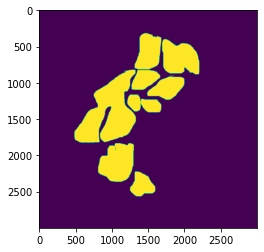

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#mask
img_1 = mpimg.imread('/content/train_masks/10044_mask.png')
imgplot = plt.imshow(img_1)
plt.show()

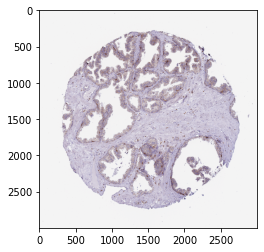

In [ ]:
#tiff orig
img_2 = mpimg.imread('/content/train_images/10044.tiff')
imgplot = plt.imshow(img_2)
plt.show()

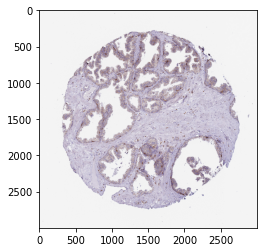

In [ ]:
#jpg version
img_2 = mpimg.imread('/content/train_images_jpg/10044.jpg')
imgplot = plt.imshow(img_2)
plt.show()

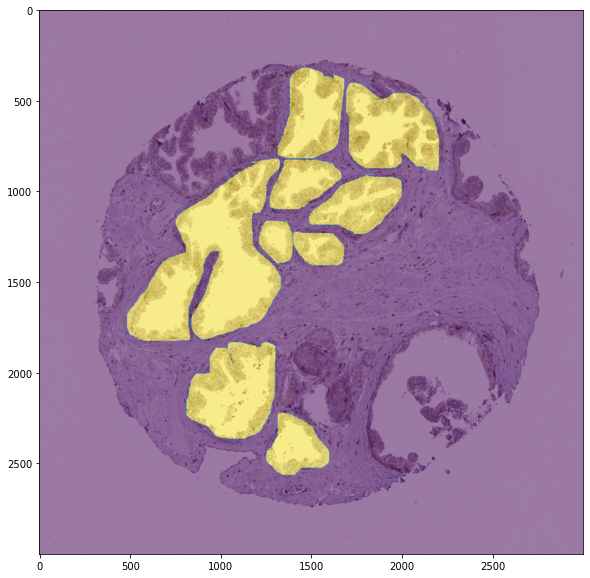

In [ ]:
#mask overlay
plt.figure(figsize = (10,10))
plt.imshow(img_1)
plt.imshow(img_2, alpha=0.5)

#### Set Train Image/Mask paths

In [ ]:
train_ids = train_df['id'].values
train_image_paths = ['/content/train_images_jpg/'+str(i)+'.jpg' for i in train_ids]

train_label_paths = ['/content/train_masks/'+str(i)+'_mask.png' for i in train_ids]

In [ ]:
#326
len(train_ids)

326

## Create Dataset

In [ ]:
import os
#import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
IMAGE_SIZE = 512
BATCH_SIZE = 8
NUM_CLASSES = 1
#DATA_DIR = "./instance-level_human_parsing/instance-level_human_parsing/Training"
NUM_TRAIN_IMAGES = 260
NUM_VAL_IMAGES = 66

train_images = train_image_paths[:NUM_TRAIN_IMAGES]
train_masks = train_label_paths[:NUM_TRAIN_IMAGES]
val_images = train_image_paths[NUM_TRAIN_IMAGES:NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]
val_masks = train_label_paths[NUM_TRAIN_IMAGES:NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]

def read_image(image_path, mask=False):
    print("img:", image_path)
    #image_arr = mpimg.imread(image_path)
    #image = tf.convert_to_tensor(image_arr)
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        #cast to bool since binary mask
        image = tf.cast(image, tf.bool)
        #cast back to float32 for dice loss function, since
        #prediction must be of same type as y_true,
        #y_true in this case is a pixewise
        #sigmoid activation value, I guess TF makes it float32
        image = tf.cast(image, tf.float32)
        print(image)
    else:
        image = tf.image.decode_jpeg(image, channels=3)
        #image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 127.5 - 1
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

def flip(image,labels):
        
    image = tf.image.random_flip_left_right(image, seed=1)
    labels = tf.image.random_flip_left_right(labels, seed=1)
    image = tf.image.random_flip_up_down(image, seed=1)
    labels = tf.image.random_flip_up_down(labels, seed=1)

    return image, labels

def color(image,labels):
    image = tf.image.random_hue(image, 0.05)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    return image, labels


def data_generator(image_list, mask_list, is_training):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    
    augmentations = [flip]
    
    if is_training:   
      for f in augmentations:
        if tf.random.uniform([1], 0, 1)>0.6:
            dataset = dataset.map(f, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks, True)
val_dataset = data_generator(val_images, val_masks, False)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

img: Tensor("args_0:0", shape=(), dtype=string)
img: Tensor("args_1:0", shape=(), dtype=string)
Tensor("Cast_1:0", shape=(512, 512, 1), dtype=float32)
img: Tensor("args_0:0", shape=(), dtype=string)
img: Tensor("args_1:0", shape=(), dtype=string)
Tensor("Cast_1:0", shape=(512, 512, 1), dtype=float32)
Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(8, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8, 512, 512, 1), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(8, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8, 512, 512, 1), dtype=tf.float32, name=None))>


## Attempt 1: Initial Baseline from old scripts LR steps = 3200

In [ ]:
#see: https://keras.io/examples/vision/deeplabv3_plus/
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


In [ ]:

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same", activation='sigmoid')(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

### Define Loss Function (DICE BCE)

In [ ]:
#see: https://github.com/aruns2120/Semantic-Segmentation-Severstal/blob/master/DeepLab%20V3%2B/SeverstalSteel_DeepLabV3%2B.ipynb
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
  
def bce_dice_loss(y_true, y_predict):
    return binary_crossentropy(y_true, y_predict) + (1-dice_coef(y_true, y_predict))

def dice_loss(y_true, y_predict):
    return (1-dice_coef(y_true, y_predict))

### Compile and Run Model

#### CHECK CUDA VERSION!

In [ ]:
# Check libcudnn8 version
!apt-cache policy libcudnn8

libcudnn8:
  Installed: 8.0.5.39-1+cuda11.1
  Candidate: 8.5.0.96-1+cuda11.7
  Version table:
     8.5.0.96-1+cuda11.7 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.5.0.96-1+cuda10.2 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.1.50-1+cuda11.6 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.1.50-1+cuda10.2 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.0.27-1+cuda11.6 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.0.27-1+cuda10.2 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.3.3.40-1+cuda11.5 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.3.3.40-1+cuda10.2

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 6s (67.0 MB/s)
(Reading database ... 155676 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155654 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+c

#### Proceed with training if CUDA version matches

In [ ]:
NUM_EPOCHS = 50

In [ ]:
starter_learning_rate = 0.0001
end_learning_rate = 0.0000001
#SHOULD BE:
#32 steps per epoch * 5epochs per run * 7 runs
#But is:
decay_steps = 3250
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=1.0)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', patience=30, mode='max', min_delta=0.05)
checkpoints = ModelCheckpoint('weights_aug_50.h5', monitor='val_dice_coef', save_weights_only=True, verbose=1, save_best_only=True, mode="max")

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate_fn),
    loss=bce_dice_loss,
    metrics=[dice_coef],
)

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=NUM_EPOCHS, callbacks=[early_stopping, checkpoints])

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

Epoch 1/50
32/32 [==============================] - ETA: 0s - loss: 0.2060 - dice_coef: 0.8564
Epoch 1: val_dice_coef improved from -inf to 0.00283, saving model to weights_aug_50.h5
32/32 [==============================] - 21s 480ms/step - loss: 0.2060 - dice_coef: 0.8564 - val_loss: 2.0305 - val_dice_coef: 0.0028
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 0.1962 - dice_coef: 0.8662
Epoch 2: val_dice_coef did not improve from 0.00283
32/32 [==============================] - 14s 443ms/step - loss: 0.1962 - dice_coef: 0.8662 - val_loss: 2.1872 - val_dice_coef: 6.5812e-04
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 0.1692 - dice_coef: 0.8844
Epoch 3: val_dice_coef improved from 0.00283 to 0.02127, saving model to weights_aug_50.h5
32/32 [==============================] - 15s 453ms/step - loss: 0.1692 - dice_coef: 0.8844 - val_loss: 1.7181 - val_dice_coef: 0.0213
Epoch 4/50
32/32 [==============================] - ETA: 0s - loss: 0.1603 - d

KeyboardInterrupt: ignored

## Attempt 2: LR steps = 1600

In [ ]:
model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_12[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

### Compile and Run Model

In [ ]:
NUM_EPOCHS = 75

In [ ]:
starter_learning_rate = 0.0001
end_learning_rate = 0.0000001
#SHOULD BE:
#32 steps per epoch * 50 epochs
#But is:
decay_steps = 1600
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=1.0)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', patience=50, mode='max', min_delta=0.025)
checkpoints = ModelCheckpoint('weights_aug_50.h5', monitor='val_dice_coef', save_weights_only=True, verbose=1, save_best_only=True, mode="max")

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate_fn),
    loss=bce_dice_loss,
    metrics=[dice_coef],
)

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=NUM_EPOCHS, callbacks=[early_stopping, checkpoints])

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

Epoch 1/75
32/32 [==============================] - ETA: 0s - loss: 1.0821 - dice_coef: 0.3225
Epoch 1: val_dice_coef improved from -inf to 0.15792, saving model to weights_aug_50.h5
32/32 [==============================] - 21s 500ms/step - loss: 1.0821 - dice_coef: 0.3225 - val_loss: 2.8586 - val_dice_coef: 0.1579
Epoch 2/75
32/32 [==============================] - ETA: 0s - loss: 0.6272 - dice_coef: 0.5568
Epoch 2: val_dice_coef improved from 0.15792 to 0.18093, saving model to weights_aug_50.h5
32/32 [==============================] - 15s 470ms/step - loss: 0.6272 - dice_coef: 0.5568 - val_loss: 24.0694 - val_dice_coef: 0.1809
Epoch 3/75
32/32 [==============================] - ETA: 0s - loss: 0.4666 - dice_coef: 0.6672
Epoch 3: val_dice_coef did not improve from 0.18093
32/32 [==============================] - 15s 460ms/step - loss: 0.4666 - dice_coef: 0.6672 - val_loss: 1.2431 - val_dice_coef: 0.1364
Epoch 4/75
32/32 [==============================] - ETA: 0s - loss: 0.3655 - dice

KeyboardInterrupt: ignored

## Attempt 3: LR steps = 5000 (higher lr over time)

In [ ]:
model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 518, 518, 3)  0           ['input_13[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 256, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

### Compile and Run Model

In [ ]:
starter_learning_rate = 0.0001
end_learning_rate = 0.0000001
#SHOULD BE:
#??
#But is:
decay_steps = 5000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=1.0)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', patience=50, mode='max', min_delta=0.025)
checkpoints = ModelCheckpoint('weights_aug_50.h5', monitor='val_dice_coef', save_weights_only=True, verbose=1, save_best_only=True, mode="max")

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate_fn),
    loss=bce_dice_loss,
    metrics=[dice_coef],
)

Epoch 1/75
32/32 [==============================] - ETA: 0s - loss: 1.1380 - dice_coef: 0.3270
Epoch 1: val_dice_coef improved from -inf to 0.17357, saving model to weights_aug_50.h5
32/32 [==============================] - 21s 502ms/step - loss: 1.1380 - dice_coef: 0.3270 - val_loss: 9.0991 - val_dice_coef: 0.1736
Epoch 2/75
32/32 [==============================] - ETA: 0s - loss: 0.6023 - dice_coef: 0.5703
Epoch 2: val_dice_coef improved from 0.17357 to 0.18657, saving model to weights_aug_50.h5
32/32 [==============================] - 15s 471ms/step - loss: 0.6023 - dice_coef: 0.5703 - val_loss: 2.4081 - val_dice_coef: 0.1866
Epoch 3/75
32/32 [==============================] - ETA: 0s - loss: 0.4456 - dice_coef: 0.6781
Epoch 3: val_dice_coef did not improve from 0.18657
32/32 [==============================] - 15s 463ms/step - loss: 0.4456 - dice_coef: 0.6781 - val_loss: 1.6052 - val_dice_coef: 0.1796
Epoch 4/75
32/32 [==============================] - ETA: 0s - loss: 0.3753 - dice_

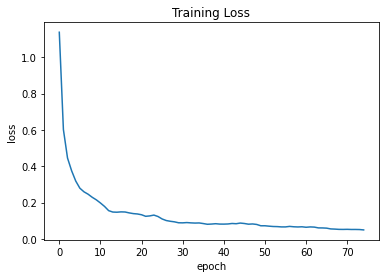

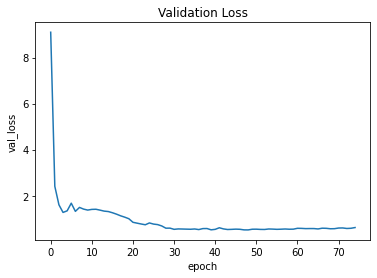

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=NUM_EPOCHS, callbacks=[early_stopping, checkpoints])

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

## Attempt 4: Reduce LRV end val = 0.000001

In [ ]:
model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)

### Compile and Run Model

In [ ]:
NUM_EPOCHS = 75
starter_learning_rate = 0.0001
end_learning_rate = 0.000001
#75epochs * 32 steps/epoch, anything lower after that so small is useless
decay_steps = 2400
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=1.0)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', patience=50, mode='max', min_delta=0.025)
checkpoints = ModelCheckpoint('weights_aug_50.h5', monitor='val_dice_coef', save_weights_only=True, verbose=1, save_best_only=True, mode="max")

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate_fn),
    loss=bce_dice_loss,
    metrics=[dice_coef],
)

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=NUM_EPOCHS, callbacks=[early_stopping, checkpoints])

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

Epoch 1/75
32/32 [==============================] - ETA: 0s - loss: 1.0824 - dice_coef: 0.3395
Epoch 1: val_dice_coef improved from -inf to 0.17065, saving model to weights_aug_50.h5
32/32 [==============================] - 22s 507ms/step - loss: 1.0824 - dice_coef: 0.3395 - val_loss: 3.2932 - val_dice_coef: 0.1707
Epoch 2/75
32/32 [==============================] - ETA: 0s - loss: 0.6321 - dice_coef: 0.5623
Epoch 2: val_dice_coef did not improve from 0.17065
32/32 [==============================] - 15s 473ms/step - loss: 0.6321 - dice_coef: 0.5623 - val_loss: 1.7319 - val_dice_coef: 0.1367
Epoch 3/75
32/32 [==============================] - ETA: 0s - loss: 0.4430 - dice_coef: 0.6862
Epoch 3: val_dice_coef did not improve from 0.17065
32/32 [==============================] - 16s 478ms/step - loss: 0.4430 - dice_coef: 0.6862 - val_loss: 1.4742 - val_dice_coef: 0.1128
Epoch 4/75
32/32 [==============================] - ETA: 0s - loss: 0.3605 - dice_coef: 0.7464
Epoch 4: val_dice_coef did

KeyboardInterrupt: ignored

## Visualize Best Results

### Imports and Functions

In [ ]:
import cv2
from operator import is_
def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    #predictions = np.argmax(predictions, axis=2)
    #predictions = np.rint(predictions)
    return predictions

def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, model, is_train = True):
    i = 0
    for image_file in images_list:
        print(i)
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        
        if is_train == True:
            mask_tensor = read_image(train_masks[i])
        else:
            mask_tensor = read_image(val_masks[i])

        plot_samples_matplotlib(
            [image_tensor, prediction_mask, mask_tensor], figsize=(18, 14)
        )
        i += 1

### Train vs Mask

0
img: /content/train_images_jpg/10044.jpg
1/1 [==============================] - 1s 1s/step
img: /content/train_masks/10044_mask.png


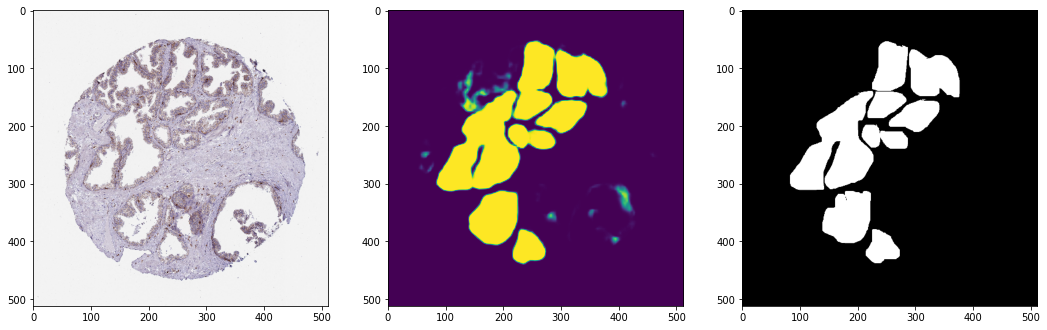

1
img: /content/train_images_jpg/10274.jpg
1/1 [==============================] - 0s 27ms/step
img: /content/train_masks/10274_mask.png


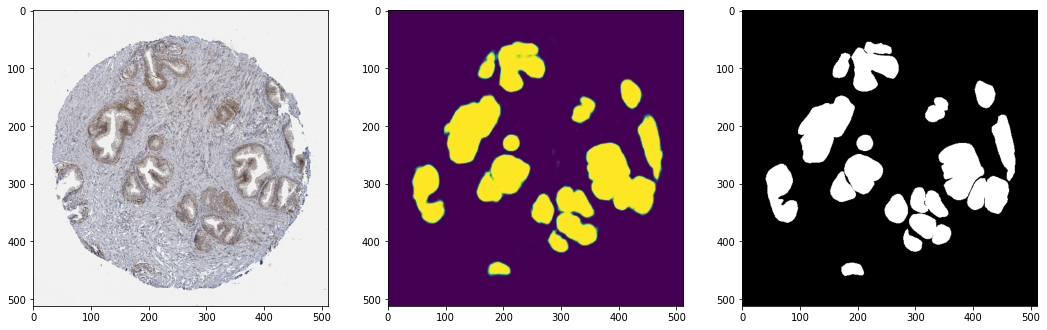

2
img: /content/train_images_jpg/10392.jpg
1/1 [==============================] - 0s 28ms/step
img: /content/train_masks/10392_mask.png


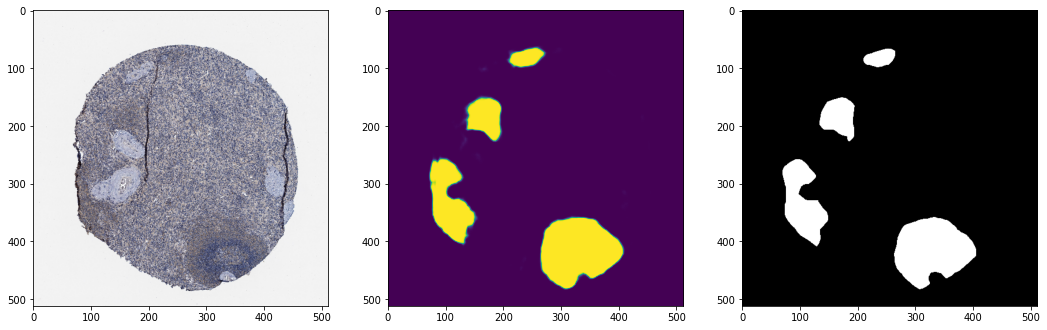

3
img: /content/train_images_jpg/10488.jpg
1/1 [==============================] - 0s 23ms/step
img: /content/train_masks/10488_mask.png


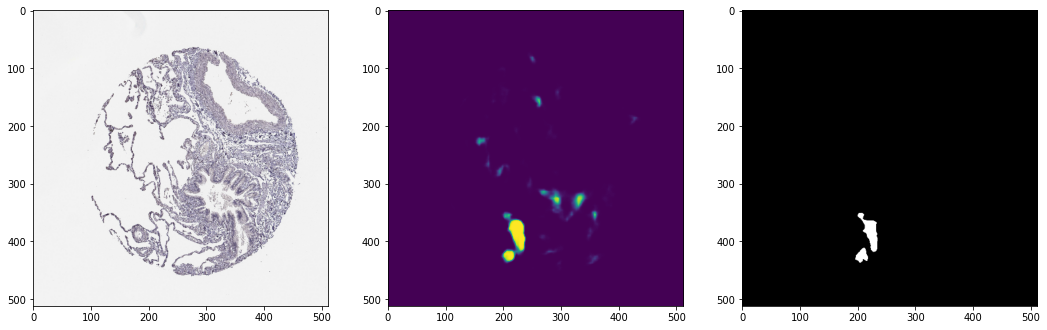

In [ ]:
plot_predictions(train_images[:4], model=model, is_train = True)

### Val vs Mask

0
img: /content/train_images_jpg/4561.jpg
1/1 [==============================] - 0s 27ms/step
img: /content/train_masks/4561_mask.png


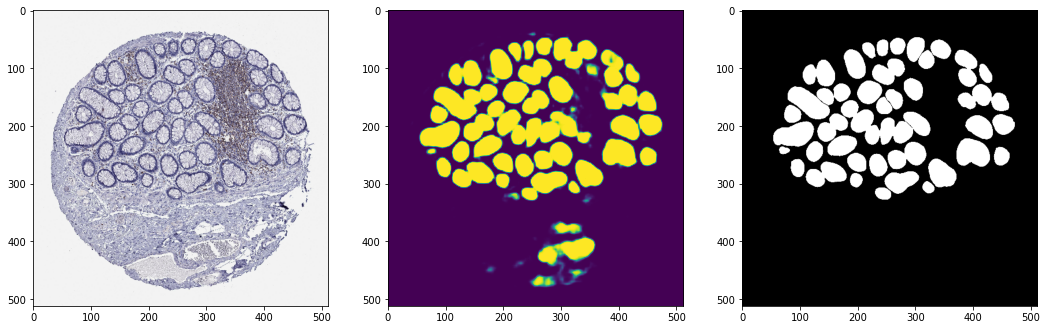

1
img: /content/train_images_jpg/4639.jpg
1/1 [==============================] - 0s 27ms/step
img: /content/train_masks/4639_mask.png


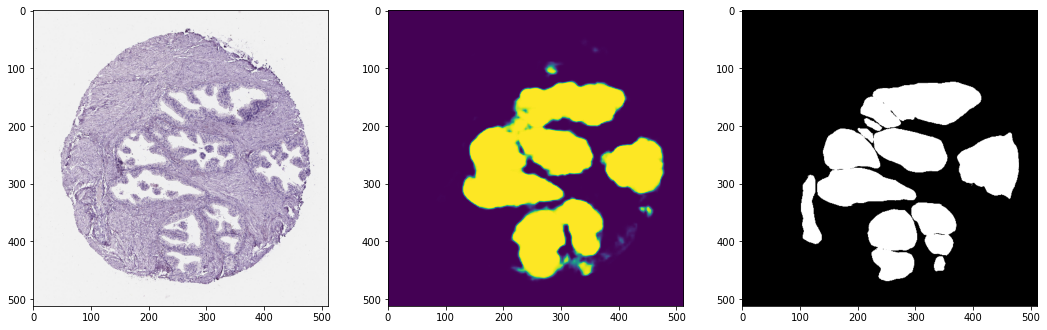

2
img: /content/train_images_jpg/4658.jpg
1/1 [==============================] - 0s 24ms/step
img: /content/train_masks/4658_mask.png


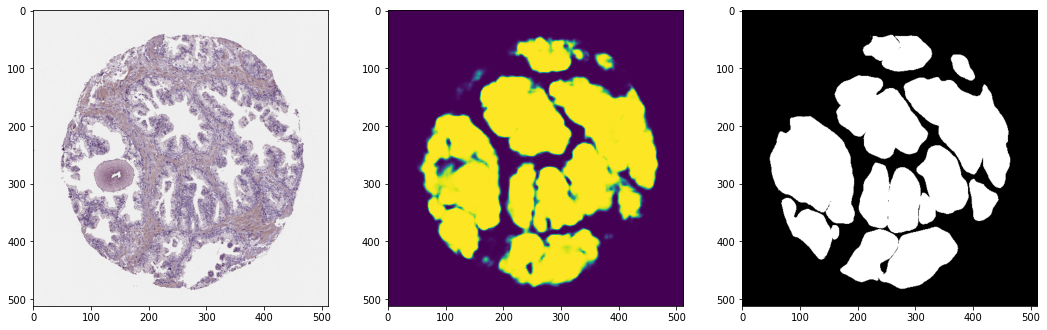

3
img: /content/train_images_jpg/4776.jpg
1/1 [==============================] - 0s 22ms/step
img: /content/train_masks/4776_mask.png


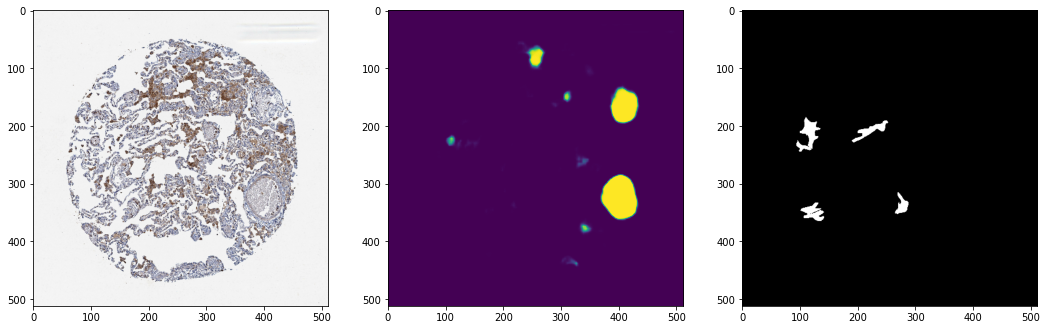

In [ ]:
plot_predictions(val_images[:4], model=model, is_train=False)

## Upsampling Data

In [ ]:
tf.random.set_seed(2022)

In [ ]:
IMAGE_SIZE = 512
BATCH_SIZE = 8
NUM_CLASSES = 1
#DATA_DIR = "./instance-level_human_parsing/instance-level_human_parsing/Training"
NUM_TRAIN_IMAGES = 260
NUM_VAL_IMAGES = 66

train_images = train_image_paths[:NUM_TRAIN_IMAGES]
train_masks = train_label_paths[:NUM_TRAIN_IMAGES]
val_images = train_image_paths[NUM_TRAIN_IMAGES:NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]
val_masks = train_label_paths[NUM_TRAIN_IMAGES:NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]

def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        #cast to bool since binary mask
        image = tf.cast(image, tf.bool)
        #cast back to float32 for dice loss function, since
        #prediction must be of same type as y_true,
        #y_true in this case is a pixewise
        #sigmoid activation value, I guess TF makes it float32
        image = tf.cast(image, tf.float32)
    else:
        image = tf.image.decode_jpeg(image, channels=3)
        #image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 127.5 - 1
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

def flip(image,labels):
        
    image = tf.image.random_flip_left_right(image, seed=1)
    labels = tf.image.random_flip_left_right(labels, seed=1)
    image = tf.image.random_flip_up_down(image, seed=1)
    labels = tf.image.random_flip_up_down(labels, seed=1)

    return image, labels

def color(image,labels):
    image = tf.image.random_hue(image, 0.05)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    return image, labels


def data_generator(image_list, mask_list, is_training):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:   
      augmentations = [flip]
      for f in augmentations:
          dataset_augmented = dataset.map(f, num_parallel_calls=tf.data.AUTOTUNE)
          dataset = dataset.concatenate(dataset_augmented)

    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks, True)
val_dataset = data_generator(val_images, val_masks, False)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(8, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8, 512, 512, 1), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(8, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8, 512, 512, 1), dtype=tf.float32, name=None))>


### Attempt 1: Upsample with flipped data baseline lr=5000step

In [ ]:
model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)

In [ ]:
starter_learning_rate = 0.0001
end_learning_rate = 0.0000001
#SHOULD BE:
#??
#But is:
decay_steps = 5000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=1.0)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', patience=50, mode='max', min_delta=0.025)
checkpoints = ModelCheckpoint('weights_aug_50.h5', monitor='val_dice_coef', save_weights_only=True, verbose=1, save_best_only=True, mode="max")

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate_fn),
    loss=bce_dice_loss,
    metrics=[dice_coef],
)

Epoch 1/75
65/65 [==============================] - ETA: 0s - loss: 0.8838 - dice_coef: 0.4224
Epoch 1: val_dice_coef improved from -inf to 0.17941, saving model to weights_aug_50.h5
65/65 [==============================] - 44s 605ms/step - loss: 0.8838 - dice_coef: 0.4224 - val_loss: 3.8422 - val_dice_coef: 0.1794
Epoch 2/75
65/65 [==============================] - ETA: 0s - loss: 0.4921 - dice_coef: 0.6515
Epoch 2: val_dice_coef did not improve from 0.17941
65/65 [==============================] - 38s 591ms/step - loss: 0.4921 - dice_coef: 0.6515 - val_loss: 1.5879 - val_dice_coef: 0.1074
Epoch 3/75
65/65 [==============================] - ETA: 0s - loss: 0.3837 - dice_coef: 0.7311
Epoch 3: val_dice_coef did not improve from 0.17941
65/65 [==============================] - 38s 584ms/step - loss: 0.3837 - dice_coef: 0.7311 - val_loss: 1.5428 - val_dice_coef: 0.0225
Epoch 4/75
65/65 [==============================] - ETA: 0s - loss: 0.3169 - dice_coef: 0.7784
Epoch 4: val_dice_coef did

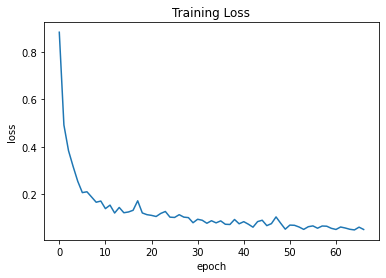

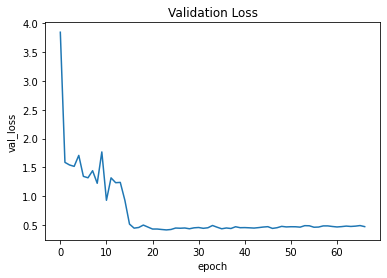

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=NUM_EPOCHS, callbacks=[early_stopping, checkpoints])

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

### Attempt 2: Upsample with flipped data, lr = 7500 step

#### Set Model Params

In [ ]:
model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)

In [ ]:
starter_learning_rate = 0.0001
end_learning_rate = 0.0000001
#SHOULD BE:
#??
#But is:
decay_steps = 7500
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=1.0)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', patience=50, mode='max', min_delta=0.025)
checkpoints = ModelCheckpoint('weights_aug_50.h5', monitor='val_dice_coef', save_weights_only=True, verbose=1, save_best_only=True, mode="max")

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate_fn),
    loss=bce_dice_loss,
    metrics=[dice_coef],
)

#### Train

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=NUM_EPOCHS, callbacks=[early_stopping, checkpoints])

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

Epoch 1/75
65/65 [==============================] - ETA: 0s - loss: 0.9283 - dice_coef: 0.4157
Epoch 1: val_dice_coef improved from -inf to 0.10488, saving model to weights_aug_50.h5
65/65 [==============================] - 45s 603ms/step - loss: 0.9283 - dice_coef: 0.4157 - val_loss: 15.4106 - val_dice_coef: 0.1049
Epoch 2/75
65/65 [==============================] - ETA: 0s - loss: 0.5049 - dice_coef: 0.6380
Epoch 2: val_dice_coef did not improve from 0.10488
65/65 [==============================] - 38s 584ms/step - loss: 0.5049 - dice_coef: 0.6380 - val_loss: 7.6391 - val_dice_coef: 0.0207
Epoch 3/75
65/65 [==============================] - ETA: 0s - loss: 0.3790 - dice_coef: 0.7297
Epoch 3: val_dice_coef did not improve from 0.10488
65/65 [==============================] - 38s 583ms/step - loss: 0.3790 - dice_coef: 0.7297 - val_loss: 2.7369 - val_dice_coef: 0.0654
Epoch 4/75
65/65 [==============================] - ETA: 0s - loss: 0.3354 - dice_coef: 0.7640
Epoch 4: val_dice_coef di

KeyboardInterrupt: ignored

#### Visualize Results

0


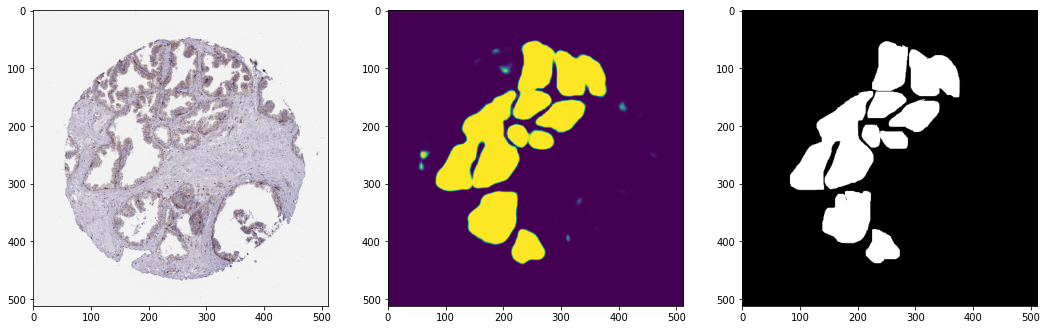

1


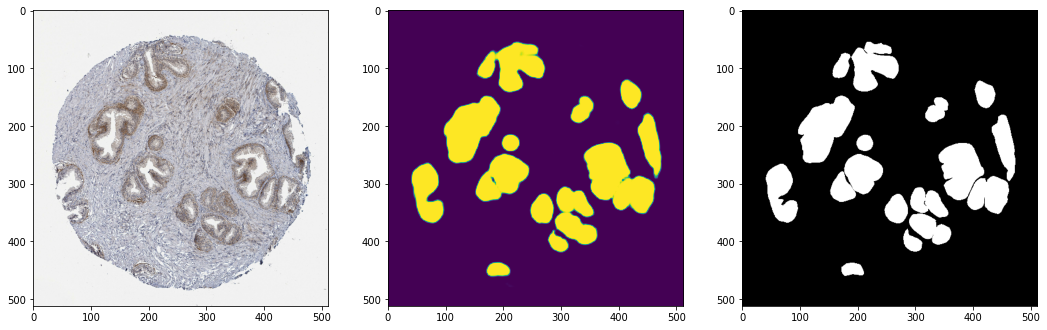

2


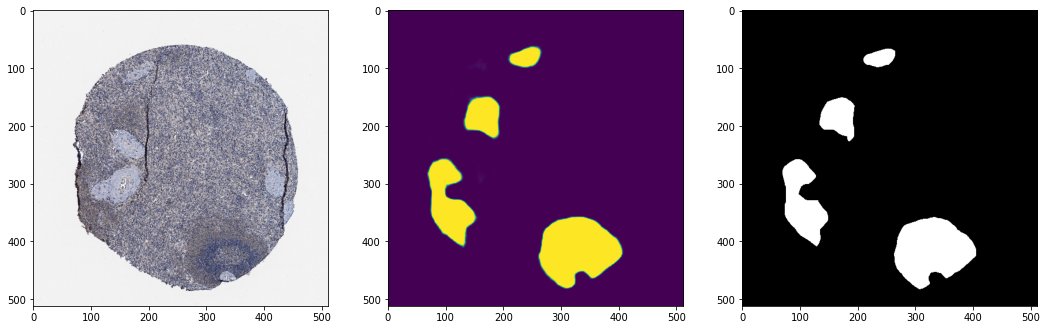

3


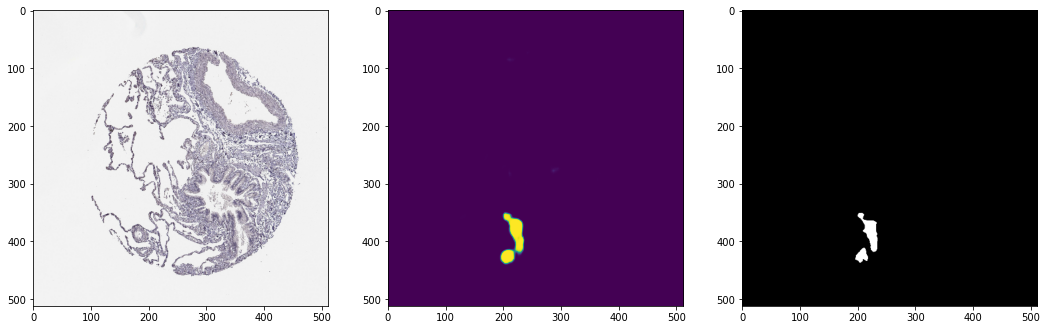

In [ ]:
plot_predictions(train_images[:4], model=model, is_train = True)

0


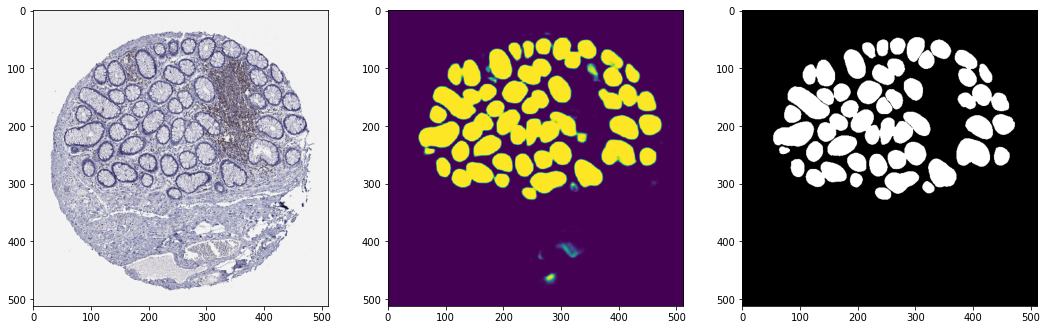

1


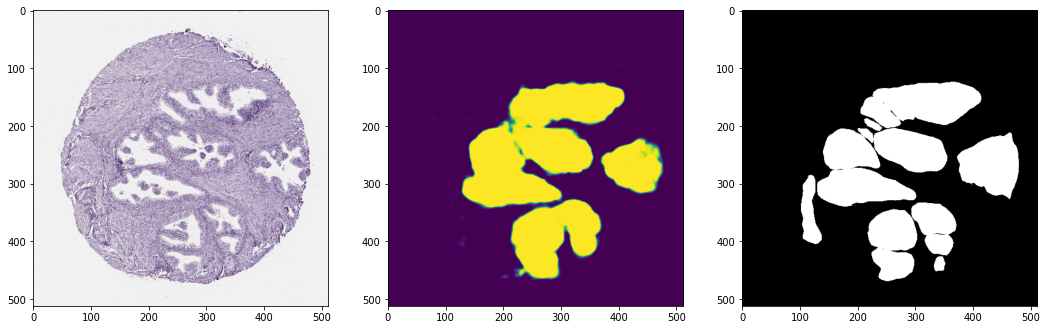

2


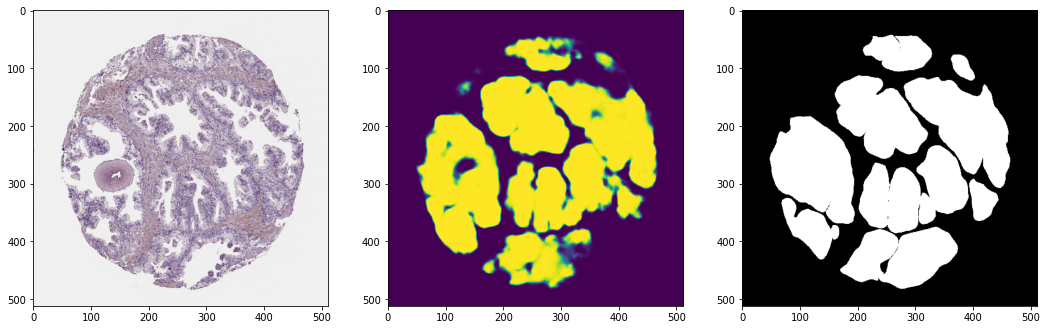

3


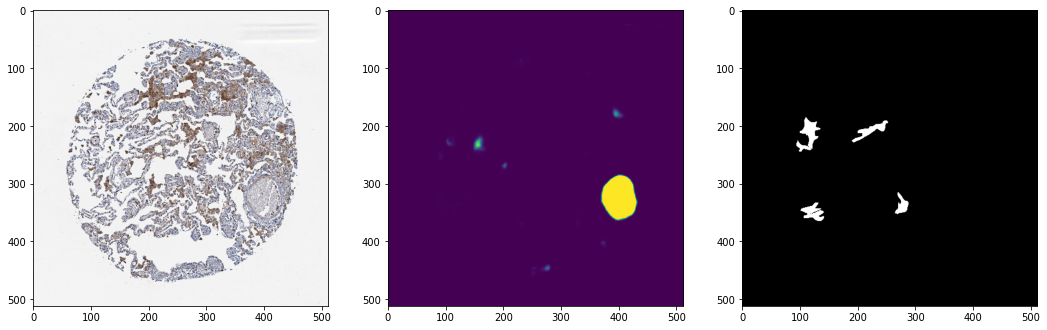

In [ ]:
plot_predictions(val_images[:4], model=model, is_train=False)

### Attempt 3: More upsampled data (4x)

#### Upsample Data

In [ ]:
IMAGE_SIZE = 512
BATCH_SIZE = 8
NUM_CLASSES = 1
#DATA_DIR = "./instance-level_human_parsing/instance-level_human_parsing/Training"
NUM_TRAIN_IMAGES = 260
NUM_VAL_IMAGES = 66

train_images = train_image_paths[:NUM_TRAIN_IMAGES]
train_masks = train_label_paths[:NUM_TRAIN_IMAGES]
val_images = train_image_paths[NUM_TRAIN_IMAGES:NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]
val_masks = train_label_paths[NUM_TRAIN_IMAGES:NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]

def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        #cast to bool since binary mask
        image = tf.cast(image, tf.bool)
        #cast back to float32 for dice loss function, since
        #prediction must be of same type as y_true,
        #y_true in this case is a pixewise
        #sigmoid activation value, I guess TF makes it float32
        image = tf.cast(image, tf.float32)
    else:
        image = tf.image.decode_jpeg(image, channels=3)
        #image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 127.5 - 1
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

def flip(image,labels):      
    image = tf.image.random_flip_left_right(image, seed=1)
    labels = tf.image.random_flip_left_right(labels, seed=1)
    image = tf.image.random_flip_up_down(image, seed=1)
    labels = tf.image.random_flip_up_down(labels, seed=1)
    return image, labels

def flip_lr(image,labels):       
    image = tf.image.random_flip_left_right(image, seed=1)
    labels = tf.image.random_flip_left_right(labels, seed=1)
    return image, labels

def flip_ud(image,labels):
    image = tf.image.random_flip_up_down(image, seed=1)
    labels = tf.image.random_flip_up_down(labels, seed=1)
    return image, labels

def color(image,labels):
    image = tf.image.random_hue(image, 0.05)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    return image, labels


def data_generator(image_list, mask_list, is_training):
    dataset_concat = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset_concat = dataset_concat.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:   
      dataset_orig = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
      dataset_orig = dataset_orig.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
      augmentations = [flip, flip_lr, flip_ud]
      for f in augmentations:
          dataset_augmented = dataset_orig.map(f, num_parallel_calls=tf.data.AUTOTUNE)
          dataset_concat = dataset_concat.concatenate(dataset_augmented)

    dataset_concat = dataset_concat.batch(BATCH_SIZE, drop_remainder=True)
    return dataset_concat


train_dataset = data_generator(train_images, train_masks, True)
val_dataset = data_generator(val_images, val_masks, False)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(8, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8, 512, 512, 1), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(8, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(8, 512, 512, 1), dtype=tf.float32, name=None))>


In [ ]:
train_dataset.cardinality().numpy()

130

#### Train

In [ ]:
model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)

In [ ]:
starter_learning_rate = 0.0001
end_learning_rate = 0.0000001
#SHOULD BE:
#??
#But is:
decay_steps = 7500
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=1.0)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coef', patience=50, mode='max', min_delta=0.025)
checkpoints = ModelCheckpoint('weights_aug_50.h5', monitor='val_dice_coef', save_weights_only=True, verbose=1, save_best_only=True, mode="max")

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate_fn),
    loss=bce_dice_loss,
    metrics=[dice_coef],
)

Epoch 1/75
130/130 [==============================] - ETA: 0s - loss: 0.7239 - dice_coef: 0.5165
Epoch 1: val_dice_coef improved from -inf to 0.12068, saving model to weights_aug_50.h5
130/130 [==============================] - 80s 575ms/step - loss: 0.7239 - dice_coef: 0.5165 - val_loss: 4.4688 - val_dice_coef: 0.1207
Epoch 2/75
130/130 [==============================] - ETA: 0s - loss: 0.3845 - dice_coef: 0.7337
Epoch 2: val_dice_coef did not improve from 0.12068
130/130 [==============================] - 74s 569ms/step - loss: 0.3845 - dice_coef: 0.7337 - val_loss: 1.2866 - val_dice_coef: 0.0953
Epoch 3/75
130/130 [==============================] - ETA: 0s - loss: 0.3073 - dice_coef: 0.7921
Epoch 3: val_dice_coef did not improve from 0.12068
130/130 [==============================] - 74s 567ms/step - loss: 0.3073 - dice_coef: 0.7921 - val_loss: 2.2445 - val_dice_coef: 0.0153
Epoch 4/75
130/130 [==============================] - ETA: 0s - loss: 0.2384 - dice_coef: 0.8390
Epoch 4: val

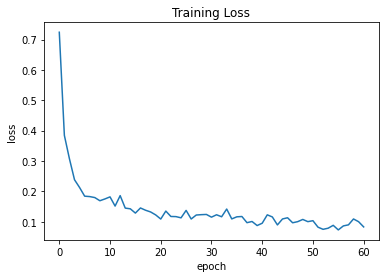

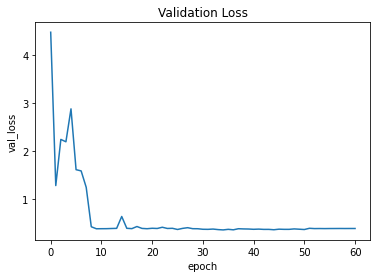

In [ ]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=NUM_EPOCHS, callbacks=[early_stopping, checkpoints])

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

#### Visualize Results

0


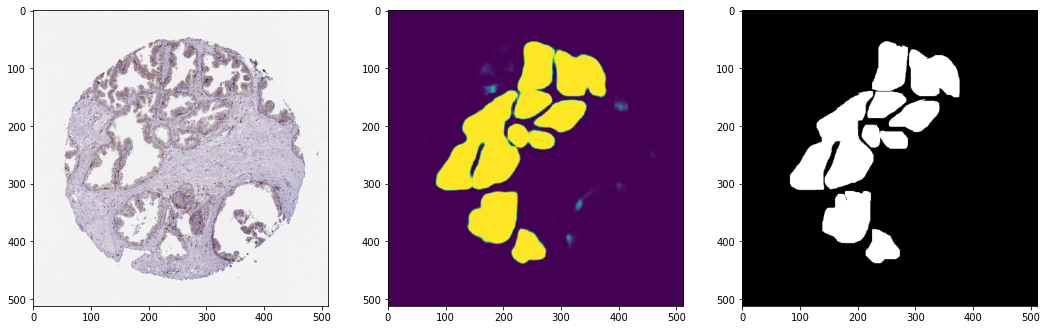

1


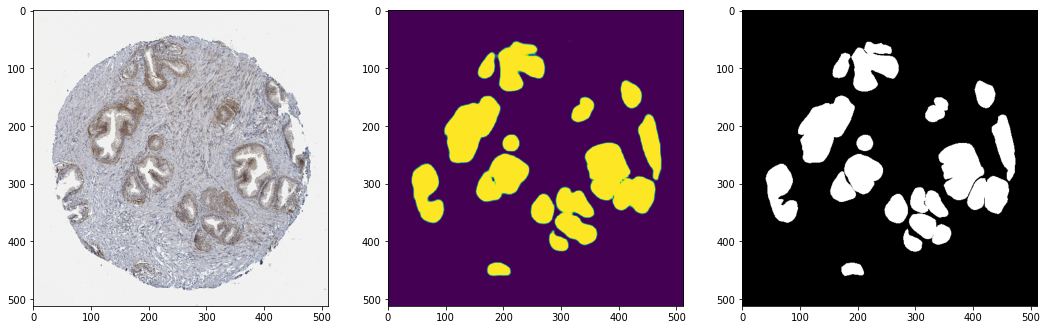

2


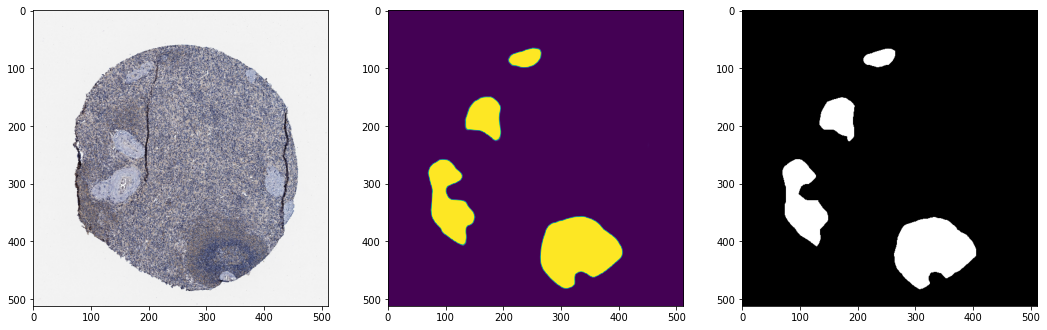

3


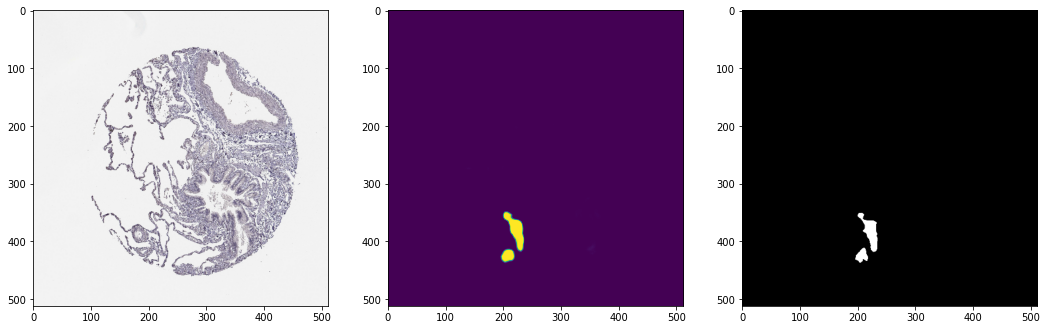

In [ ]:
plot_predictions(train_images[:4], model=model, is_train = True)

0


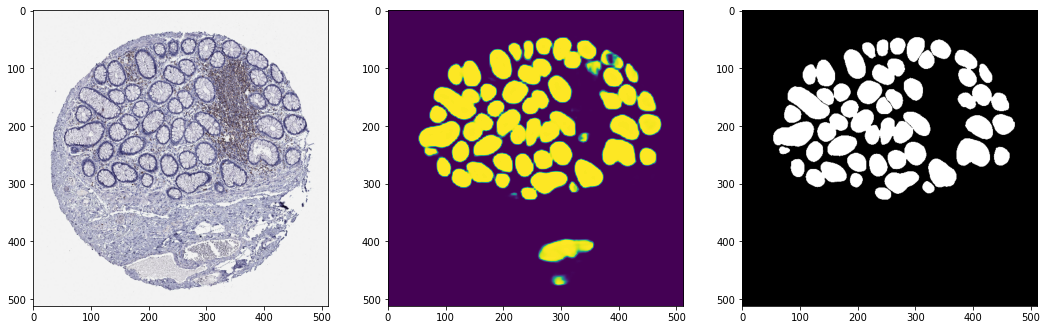

1


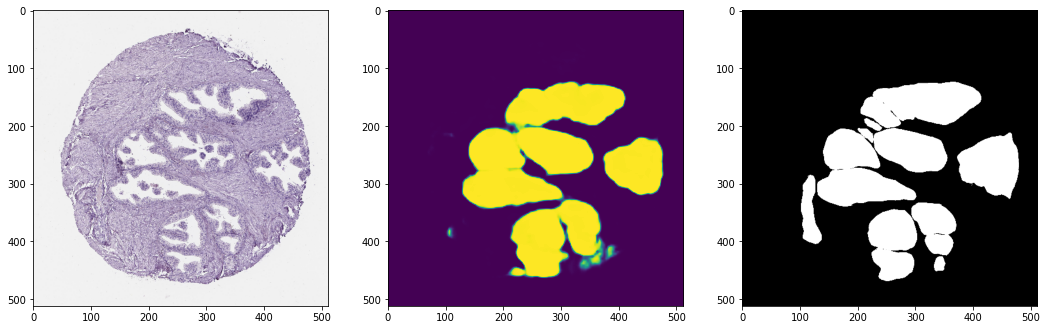

2


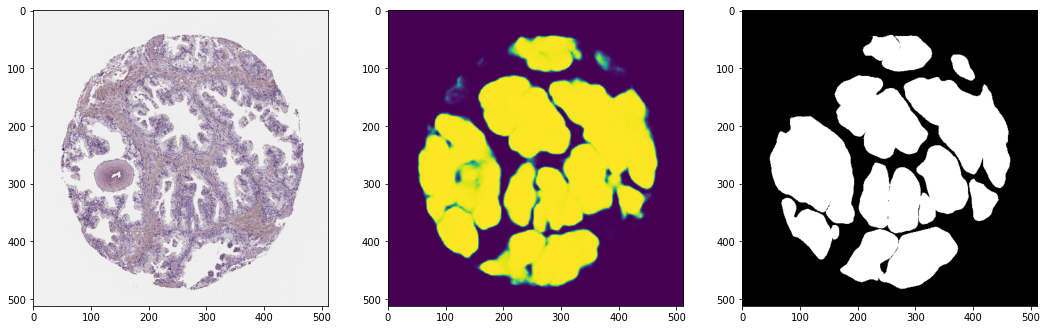

3


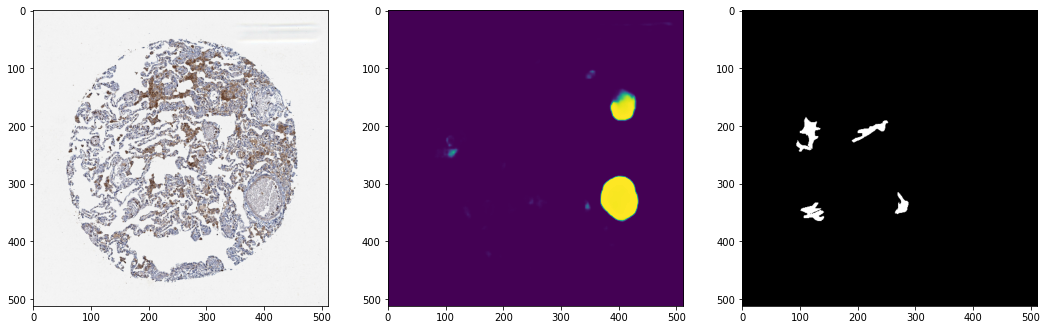

4


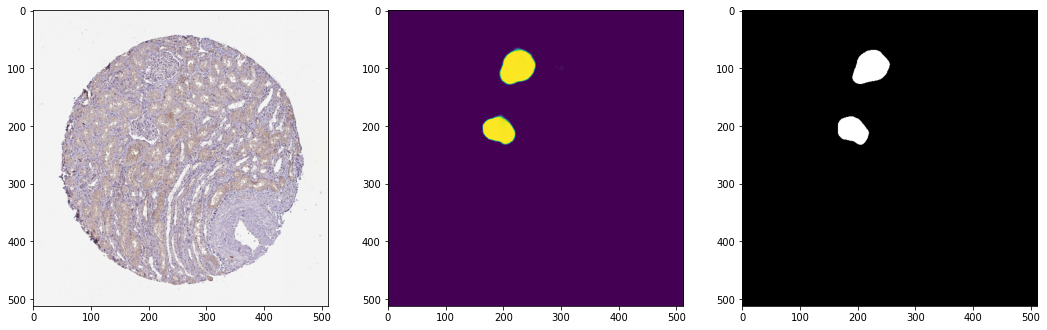

5


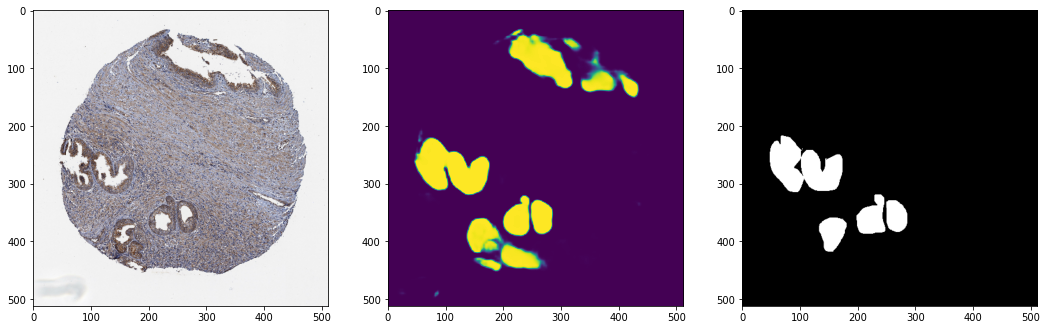

In [ ]:
plot_predictions(val_images[:6], model=model, is_train=False)

## Ideas going forward:

** Shuffle the augmented data, change LR

** Finetune multiple models on specific types of organs. I.e. train entire model, then for each class of organ, make a new model_kidney then as a dataset just feed it kidney examples. That way it learns generalized patterns, but then has a custom model for each class which has some different patterns in it

** Also just train a model using one specific class of images, normally then upsampled 2/4x, etc.

** Bounding Box but meh

** Different backbone?

** Testing against leaderboard